In [1]:
#utils
import json
from ml_utils import ml
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split

#models
import lightgbm as lgb
from xgboost import XGBClassifier

#metrics
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, confusion_matrix
import kds

#saving_model
import pickle
import re

In [2]:
#!pip install lightgbm==2.2.3

## ML Model

For the ML model, I used 2 different models and evaluated its metrics:

- XGBoost.
- LGBM.

This two models are known for its robustness, and also really fast computing results compared with other models.

This models are tree-based, using the best of the Gradient Boosting model and its propierties. Also, this two models have the propierty that they can encode missing values, and this dataset has some of them.

A missing value can be information if the field allows it to.

In [3]:
df = pd.read_parquet('../data/staging/final_df.parquet')

In [4]:
df.head()

,warranty,condition,deal_ids,base_price,listing_type_id,buying_mode,parent_item_id,category_id,official_store_id,accepts_mercadopago,...,last_updated_second,date_created_year,date_created_month,date_created_day,date_created_hour,date_created_minute,date_created_second,stop_time_minute,stop_time_second,start_time_second
id,,,,,,,,,,,,,,,,,,,,,
MLA4695330653,otros,new,no,80.0,bronze,buy_it_now,yes,others,no,yes,...,58,2015,9,5,20,42,53,24,6,1
MLA7160447179,otros,used,no,2650.0,silver,buy_it_now,yes,others,no,yes,...,34,2015,9,26,18,8,30,24,8,3
MLA7367189936,otros,used,no,60.0,bronze,buy_it_now,yes,mla1227,no,yes,...,10,2015,9,9,23,57,7,24,7,1
MLA9191625553,otros,new,no,580.0,silver,buy_it_now,no,others,no,yes,...,50,2015,9,28,18,47,56,24,9,3
MLA7787961817,otros,used,no,30.0,bronze,buy_it_now,yes,mla41287,no,yes,...,41,2015,8,24,22,7,20,24,5,0


### Variable transformations and encoding

In this step, two things happen:

- One hot encoding of categorical features.
- Min-max scaling of numerical features.

**Note: no NaN imputation done because the relation between non-missing and missing values is too high in the variables with missing values. For this matter, models like LGBM and XGBoost will be used for the exercise.**

In [5]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

df_cat_dummies = pd.get_dummies(df[categorical_cols], drop_first=True)

scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(
    scaler.fit_transform(df[numeric_cols]),
    columns=numeric_cols,
    index=df.index
)

df = pd.concat([df_numeric_scaled, df_cat_dummies], axis=1)

In [6]:
df.shape

(100000, 196)

In [7]:
print(f'Used percentage: {100*df.condition_used.sum()/ df.shape[0]}')

Used percentage: 46.242


### Partitions - Train and Test

In [8]:
X = df.drop(columns=['condition_used'])
y = df['condition_used']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

### Considerations for the Metric  

In this notebook, the chosen optimization metric is **accuracy**, primarily because the test required achieving a minimum of **86%**.  

However, for balanced classification problems like this one, alternative metrics such as **AUC-ROC, AUC-PR, F1-score**, and others can also be considered.  

### Alternative Metric Proposal – AUC-PR  

During the development of this exercise, you will find outputs displaying the **AUC-PR (Area Under the Precision-Recall Curve) metric**.  

This metric can be particularly useful for problems like this for the following reasons:  

- **Accuracy treats all misclassifications equally.** If false positives and false negatives have different consequences, accuracy might not accurately reflect model performance.  
- **Precision and recall can be more meaningful than accuracy,** even in balanced datasets, when the goal is to maximize correct positive predictions.  
- **AUC-PR summarizes the trade-off between precision (quality of positive predictions) and recall (coverage of actual positives),** providing a more insightful evaluation than accuracy.  
- **AUC-PR helps assess how well the model retrieves the positive class while minimizing false positives,** making it particularly useful for decision-making in real-world applications.  
- **Unlike accuracy, which depends on a fixed threshold, AUC-PR evaluates model performance across all thresholds,** making it a more stable and robust metric for comparison.  

In this exercise, I did not calibrate the model using AUC-PR, as the objective was to optimize accuracy to **86% or higher**. However, in practice, AUC-PR provides valuable insight by assessing the model’s ability to differentiate between the two classes while considering both **precision and recall**.  


### First model -- XGBoost

In [10]:
param_grid_xgb = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'subsample': [0.7, 0.8, 1.0]
}

In [11]:
xgb_clf = XGBClassifier(
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

In [12]:
grid_search_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [13]:
%%time
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\EJLL\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [14:08:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: total: 2min 44s
Wall time: 24min 2s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [5, 7, 9],
                         'n_estimators': [200, 300, 400],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [14]:
print("Best parameters founded: XGB:")
print(grid_search_xgb.best_params_)

Best parameters founded: XGB:
{'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 400, 'subsample': 1.0}


In [15]:
print("CV XGB Train (Accuracy):")
print(grid_search_xgb.best_score_)

CV XGB Train (Accuracy):
0.8622571428571428


**First result:** in training, XGBoost has a 86.22% accuracy, more than the proposed goal of 86%.

In [16]:
best_model_xgb = grid_search_xgb.best_estimator_

<Axes: xlabel='feature'>

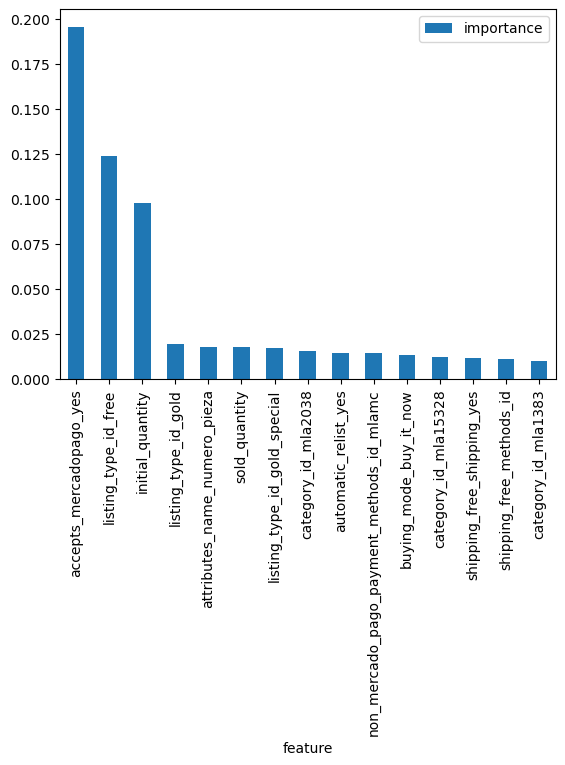

In [17]:
importance = best_model_xgb.feature_importances_
imporFrame = pd.DataFrame({'feature': X_train.columns.to_list(), 'importance':importance})
imporFrame = imporFrame.sort_values(by = 'importance', ascending = False)
imporFrame = imporFrame[imporFrame.importance > 0]
imporFrame = imporFrame.head(15)
imporFrame.plot.bar(x = 'feature')

**Feature importance**: can see that the variables that were noted in the EDA process, can differentiate really well the problem of used and new items in MercadoLibre. The most important one: if the seller accepts MercadoPago.

#### Testing XGBoost

In [18]:
y_pred_xgb = best_model_xgb.predict(X_test)
y_pred_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1] 

In [19]:
acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_pr_xgb = average_precision_score(y_test, y_pred_proba_xgb)

In [20]:
print("TEST: XGB Accuracy:", acc_xgb)
print("TEST: XGB AUC-PR:", auc_pr_xgb)

TEST: XGB Accuracy: 0.8624666666666667
TEST: XGB AUC-PR: 0.9244567785574882


**The problem passes the test with 86.2% of accuracy**, predicting correctly the 86.2% of the escenarios. Also **the proposed metric AUC-PR has a great performance**, with 92% it means that the model has strong performance in distinguishing the positive class while balancing precision and recall.

In [21]:
print("TEST: XGB - Classification report:")
print(classification_report(y_test, y_pred_xgb))

TEST: XGB - Classification report:
              precision    recall  f1-score   support

       False       0.89      0.85      0.87     16127
        True       0.84      0.87      0.85     13873

    accuracy                           0.86     30000
   macro avg       0.86      0.86      0.86     30000
weighted avg       0.86      0.86      0.86     30000



Text(0.5, 23.52222222222222, 'Predictions')

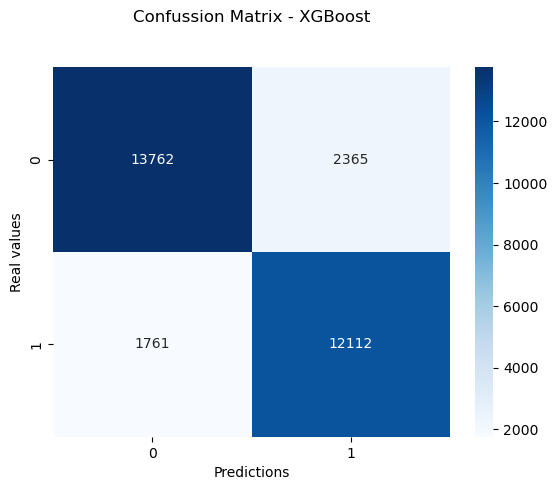

In [22]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(
    pd.DataFrame(cm_xgb),
    annot = True,
    annot_kws = {'size':10},
    cmap = "Blues",
    fmt = 'g'
) 
plt.title('Confussion Matrix - XGBoost', y = 1.1)
plt.ylabel('Real values')
plt.xlabel('Predictions')

**Checking the distribution** can see that the model can differentitate really well both categories, the used and new items, even with probabilities, having two very different probabilities curve for each class.

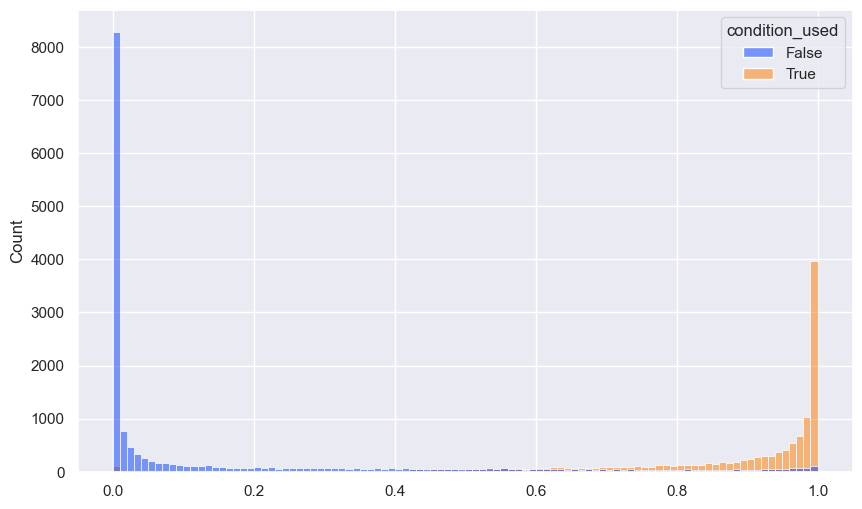

In [23]:
sns.set(font_scale = 1)
fig, axes = plt.subplots(1, 1, figsize = (10, 6))
sns.histplot(x = y_pred_proba_xgb, hue = y_test, palette = 'bright', bins = 100)
plt.show()

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.996,1.000,0.999,3000.0,2958.0,42.0,1387.3,3000,98.600,3000.0,2958.0,3000,42.0,10.0,21.322,21.625,0.260,21.062,2.132
1,2,0.969,0.996,0.985,3000.0,2794.0,206.0,1387.3,3000,93.133,6000.0,5752.0,6000,248.0,20.0,41.462,43.249,1.538,39.924,2.073
2,3,0.889,0.969,0.935,3000.0,2635.0,365.0,1387.3,3000,87.833,9000.0,8387.0,9000,613.0,30.0,60.456,64.874,3.801,56.655,2.015
3,4,0.709,0.889,0.808,3000.0,2280.0,720.0,1387.3,3000,76.000,12000.0,10667.0,12000,1333.0,40.0,76.890,86.499,8.266,68.624,1.922
4,5,0.446,0.709,0.584,3000.0,1687.0,1313.0,1387.3,1873,56.233,15000.0,12354.0,13873,2646.0,50.0,89.051,100.000,16.407,72.644,1.781
5,6,0.155,0.446,0.298,3000.0,1010.0,1990.0,1387.3,0,33.667,18000.0,13364.0,13873,4636.0,60.0,96.331,100.000,28.747,67.584,1.606
6,7,0.016,0.155,0.067,3000.0,380.0,2620.0,1387.3,0,12.667,21000.0,13744.0,13873,7256.0,70.0,99.070,100.000,44.993,54.077,1.415
7,8,0.002,0.016,0.006,3000.0,91.0,2909.0,1387.3,0,3.033,24000.0,13835.0,13873,10165.0,80.0,99.726,100.000,63.031,36.695,1.247
8,9,0.000,0.002,0.001,3000.0,32.0,2968.0,1387.3,0,1.067,27000.0,13867.0,13873,13133.0,90.0,99.957,100.000,81.435,18.522,1.111
9,10,0.000,0.000,0.000,3000.0,6.0,2994.0,1387.3,0,0.200,30000.0,13873.0,13873,16127.0,100.0,100.000,100.000,100.000,0.000,1.000


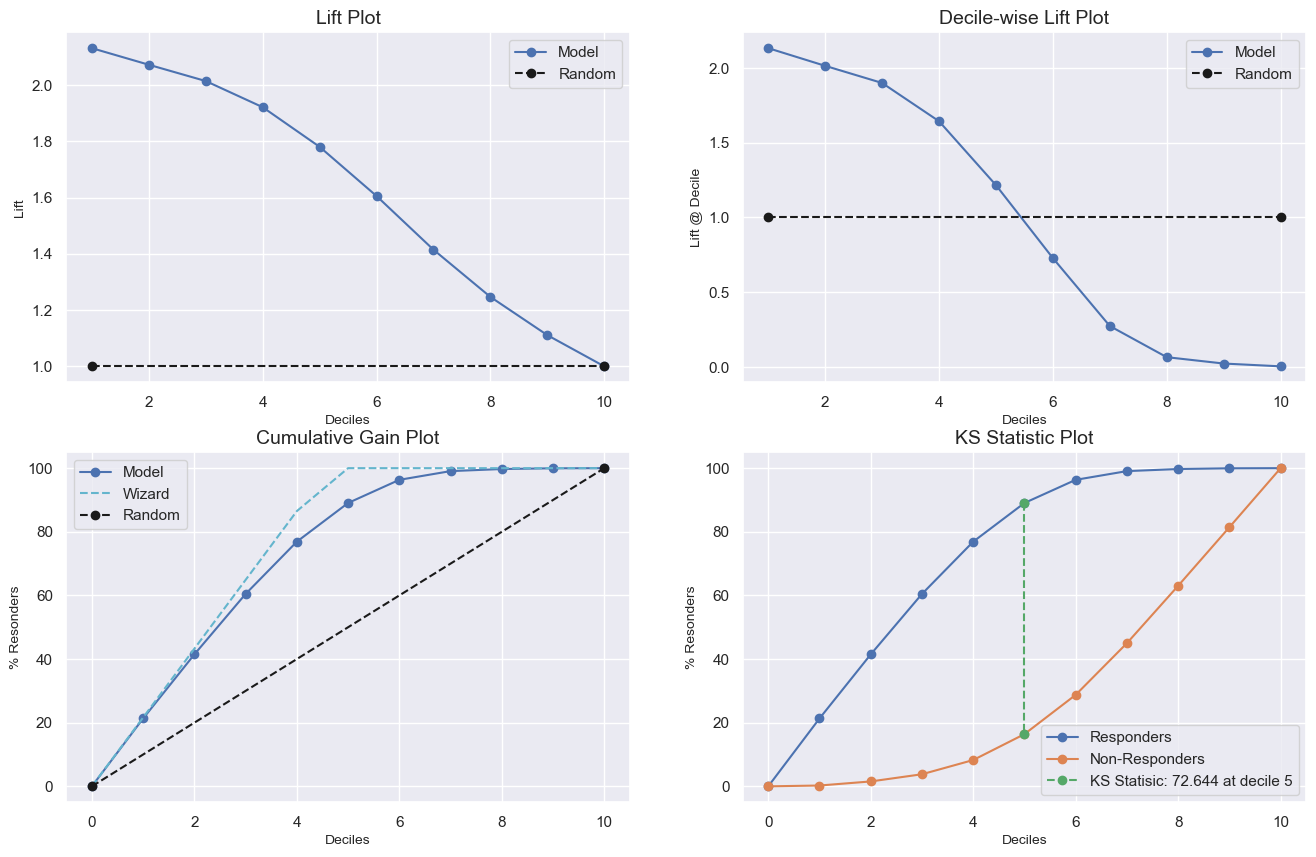

In [24]:
kds.metrics.report(y_test, y_pred_proba_xgb)

**In this KDS report** can see that the model has a very good capability of differentiating between both clases in different ranges of probability. In the highest probabilities, the model predicts the used label in 98.6% of the cases, having almost no space for error!

### Second model -- LightGBM

In [25]:
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],  
    'colsample_bytree': [0.7, 0.8, 1.0],
    'subsample': [0.7, 0.8, 1.0]
}

In [26]:
lgbm_clf = lgb.LGBMClassifier(
    random_state=42,
    metric='binary_logloss'
)

In [27]:
grid_search_lgbm = GridSearchCV(
    estimator=lgbm_clf,
    param_grid=param_grid_lgbm,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=2
)

In [28]:
%%time
grid_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
CPU times: total: 2min 35s
Wall time: 43min 12s


GridSearchCV(cv=5,
             estimator=LGBMClassifier(metric='binary_logloss', random_state=42),
             n_jobs=2,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [31, 50, 100],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [29]:
print("Best parameters founded: LGBM:")
print(grid_search_lgbm.best_params_)

Best parameters founded: LGBM:
{'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'num_leaves': 100, 'subsample': 0.7}


**In the LGBM model the performance in training passes the proposed threshold of 86%**, but it is on the limit and is lower than the training accuracy of the XGB.

In [30]:
print("CV LGBM Train (Accuracy):")
print(grid_search_lgbm.best_score_)

CV LGBM Train (Accuracy):
0.8606000000000001


In [31]:
best_model_lgbm = grid_search_lgbm.best_estimator_

<Axes: xlabel='feature'>

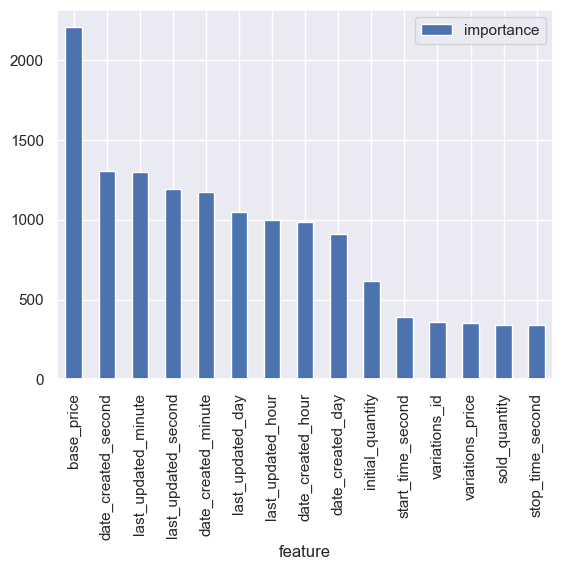

In [32]:
importance = best_model_lgbm.feature_importances_
imporFrame = pd.DataFrame({'feature': X_train.columns.to_list(), 'importance':importance})
imporFrame = imporFrame.sort_values(by = 'importance', ascending = False)
imporFrame = imporFrame[imporFrame.importance > 0]
imporFrame = imporFrame.head(15)
imporFrame.plot.bar(x = 'feature')

**The feature importance changes a bit in this model**, giving a lot of importance to the price of the items, and to the time-ish features that were created in the depuration of the dataset.

This feature importance is not that good for the business decition making process, because maps features that in many cases are not in control of the company.

#### Testing LGBM

In [33]:
y_pred_lgbm = best_model_lgbm.predict(X_test)
y_pred_proba_lgbm = best_model_lgbm.predict_proba(X_test)[:, 1] 

In [34]:
acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
auc_pr_lgbm = average_precision_score(y_test, y_pred_proba_lgbm)

In [35]:
print("TEST: LGBM Accuracy:", acc_lgbm)
print("TEST: LGBM AUC-PR:", auc_pr_lgbm)

TEST: LGBM Accuracy: 0.8609
TEST: LGBM AUC-PR: 0.9247373530213944


**This model also performs well in the Test validation, with 86.06% of accuracy, and also more than 92% of AUC-PR**.

However, the metrics are lower than the XGB model, and for decision making process, the features maped in the XGB model can be more robust for the company.

In [36]:
print("TEST: LGBM - Classification report:")
print(classification_report(y_test, y_pred_lgbm))

TEST: LGBM - Classification report:
              precision    recall  f1-score   support

       False       0.88      0.85      0.87     16127
        True       0.84      0.87      0.85     13873

    accuracy                           0.86     30000
   macro avg       0.86      0.86      0.86     30000
weighted avg       0.86      0.86      0.86     30000



Text(0.5, 20.049999999999997, 'Predictions')

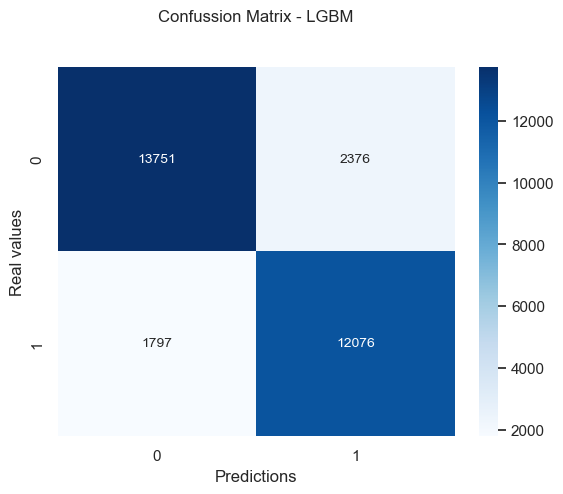

In [37]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

sns.heatmap(
    pd.DataFrame(cm_lgbm),
    annot = True,
    annot_kws = {'size':10},
    cmap = "Blues",
    fmt = 'g'
) 
plt.title('Confussion Matrix - LGBM', y = 1.1)
plt.ylabel('Real values')
plt.xlabel('Predictions')

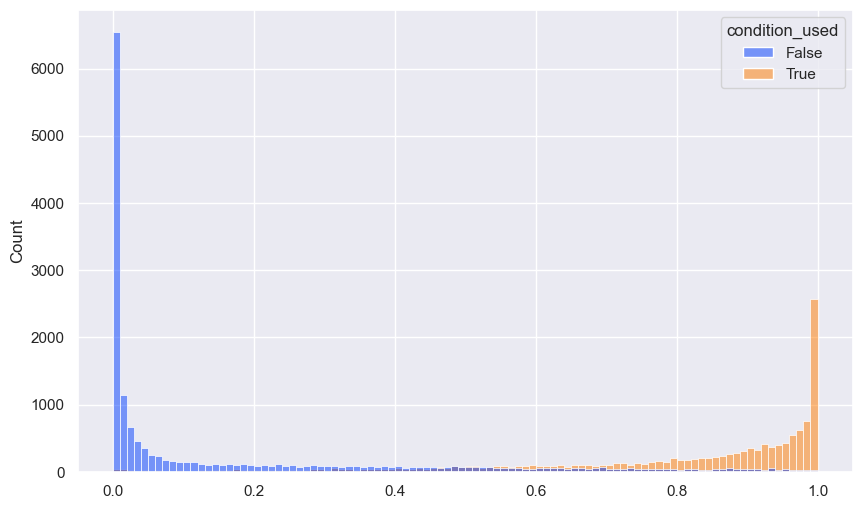

In [38]:
sns.set(font_scale = 1)
fig, axes = plt.subplots(1, 1, figsize = (10, 6))
sns.histplot(x = y_pred_proba_lgbm, hue = y_test, palette = 'bright', bins = 100)
plt.show()

**This model also discriminates really well both categories, with lower acumulation peaks on the extreme predictions of used (0s and 1s).** 

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.985,1.000,0.996,3000.0,2957.0,43.0,1387.3,3000,98.567,3000.0,2957.0,3000,43.0,10.0,21.315,21.625,0.267,21.048,2.132
1,2,0.928,0.985,0.960,3000.0,2800.0,200.0,1387.3,3000,93.333,6000.0,5757.0,6000,243.0,20.0,41.498,43.249,1.507,39.991,2.075
2,3,0.835,0.928,0.886,3000.0,2623.0,377.0,1387.3,3000,87.433,9000.0,8380.0,9000,620.0,30.0,60.405,64.874,3.844,56.561,2.014
3,4,0.671,0.834,0.759,3000.0,2274.0,726.0,1387.3,3000,75.800,12000.0,10654.0,12000,1346.0,40.0,76.797,86.499,8.346,68.451,1.920
4,5,0.461,0.671,0.567,3000.0,1686.0,1314.0,1387.3,1873,56.200,15000.0,12340.0,13873,2660.0,50.0,88.950,100.000,16.494,72.456,1.779
5,6,0.217,0.461,0.339,3000.0,1005.0,1995.0,1387.3,0,33.500,18000.0,13345.0,13873,4655.0,60.0,96.194,100.000,28.865,67.329,1.603
6,7,0.041,0.217,0.114,3000.0,399.0,2601.0,1387.3,0,13.300,21000.0,13744.0,13873,7256.0,70.0,99.070,100.000,44.993,54.077,1.415
7,8,0.007,0.041,0.019,3000.0,92.0,2908.0,1387.3,0,3.067,24000.0,13836.0,13873,10164.0,80.0,99.733,100.000,63.025,36.708,1.247
8,9,0.001,0.007,0.003,3000.0,34.0,2966.0,1387.3,0,1.133,27000.0,13870.0,13873,13130.0,90.0,99.978,100.000,81.416,18.562,1.111
9,10,0.000,0.001,0.000,3000.0,3.0,2997.0,1387.3,0,0.100,30000.0,13873.0,13873,16127.0,100.0,100.000,100.000,100.000,0.000,1.000


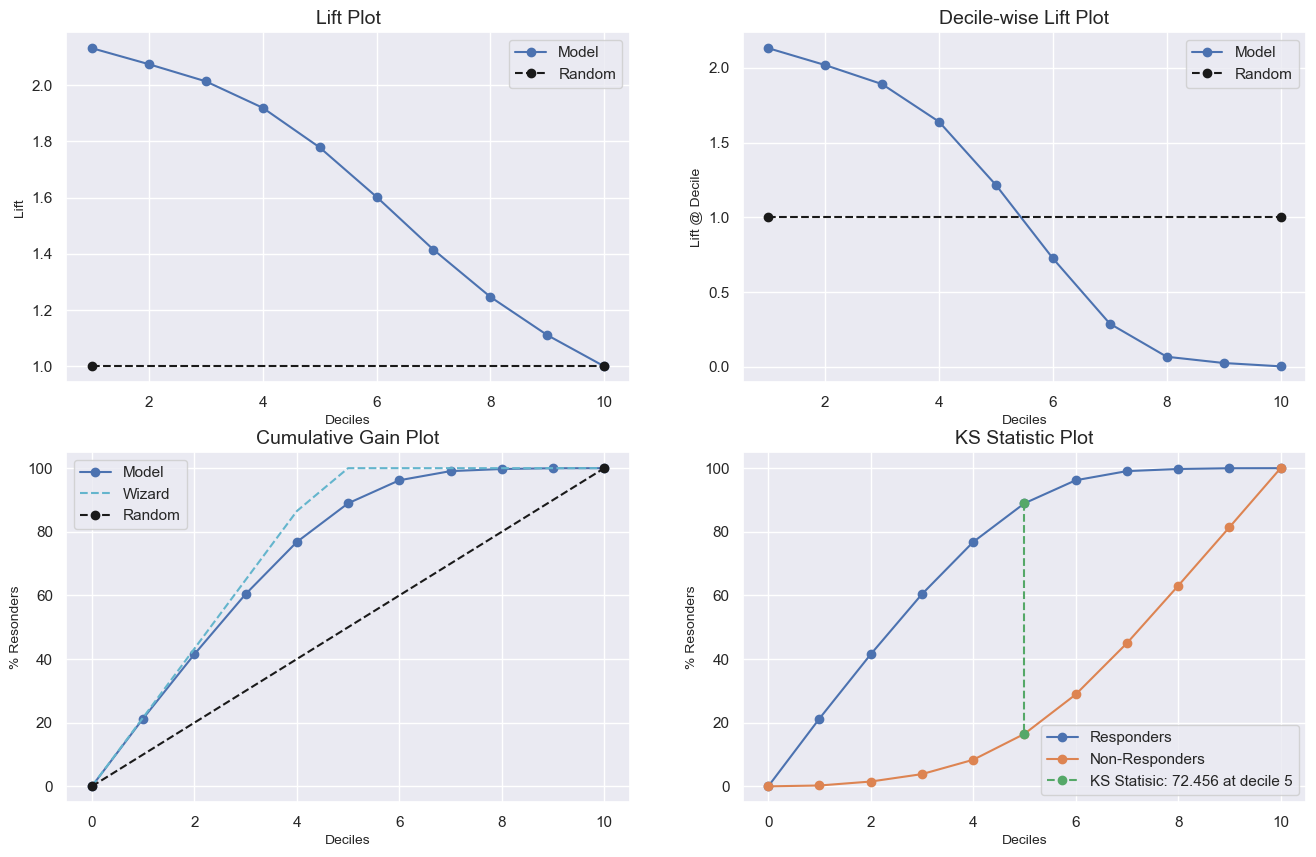

In [39]:
kds.metrics.report(y_test, y_pred_proba_lgbm)

In this case, the model performs also excellent in the highest and lower probabilities, as the XGBoost.

- **In the highest probabilities, 98.5% are used.**
- **In the lowest probabilities, only 0.1% are used, with 99.9% of new items.**

Which talks of the great capacity of the model on picking the best prediction for each set of variables.

### Choosing the best model

This decision was taken only with **accuracy**, because it is the metric of the exercise.

**However, both models have very good accuracy, precision, recall and AUC-PR metrics, and to be realistic, both models would do a really good job in production**.

As I mentioned previously, I would preffer the XGBoost because it maps as important some features that are very relevant for the business decision making.

In [40]:
if acc_xgb >= acc_lgbm:
    print('Best model: XGB')
    print(f'Accuracy: {acc_xgb}')
    print(f'AUC-PR: {auc_pr_xgb}')
    final_model = best_model_xgb
else:
    print('Best model: LGBM')
    print(f'Accuracy: {acc_lgbm}')
    print(f'AUC-PR: {auc_pr_lgbm}')
    final_model = best_model_lgbm 

Best model: XGB
Accuracy: 0.8624666666666667
AUC-PR: 0.9244567785574882


In [52]:
with open('../resources/pkl/final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

### Extra: Shap values

With SHAP we can measure, in some way, which variables impact the higher values of the probability, and the lower values of the probability. So, the id free generates a big impact on the items listed as high probability for used.

Also, the lower base price impacts and generates a higher probability for the used items.

And so on. With shap values, you can map in general and for each observation which feature has the biggest impact in the predictions.

**This is useful for generating insights and specifical actions for strategies and to be aligned with the stakeholders ideas.**

In [42]:
import shap

In [49]:
X_train = X_train.astype({col: int for col in X_train.select_dtypes(include=bool).columns})
X_test = X_test.astype({col: int for col in X_test.select_dtypes(include=bool).columns})

explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test)

100%|===================| 29996/30000 [09:22<00:00]        

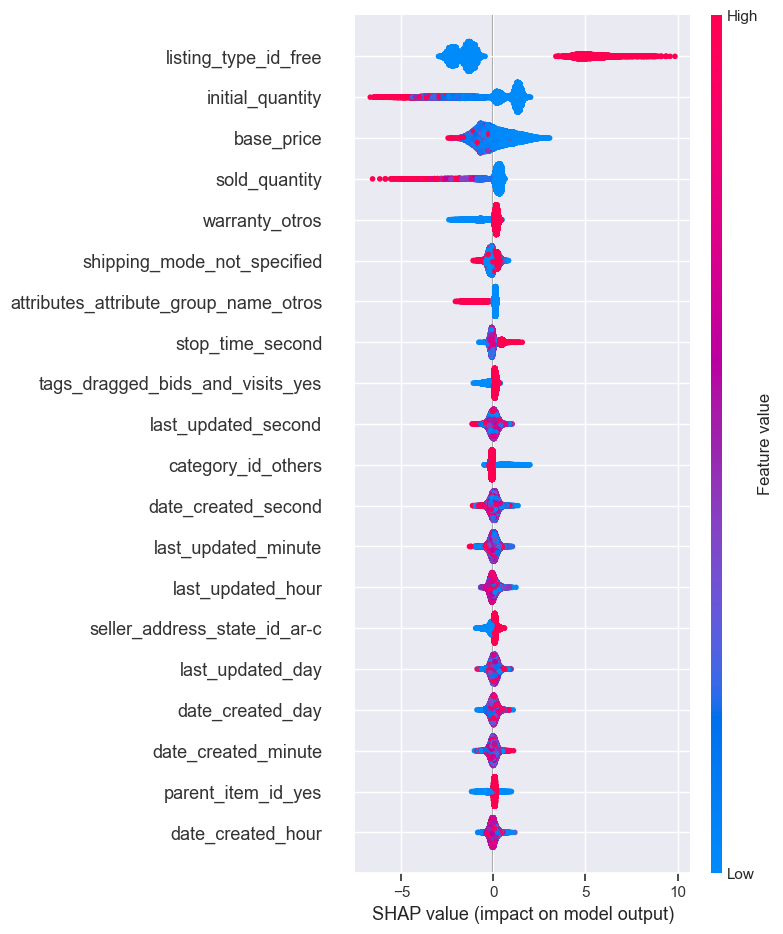

In [50]:
shap.summary_plot(shap_values, X_test)